# Deep Learning
## Practice Projects
# P2: Multi-Label Classification

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [1]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #818286; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
# Plot the neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

# Step 1. Load and Explore the Data
For this project, I have created the dataset of 5940 (180x33) color images (32x32x3) with 33 handwritten letters.
Run the following cell to download the dataset.

In [4]:
# Function for processing an image
def image_to_tensor(img_path, folder_path):
    img = keras_image.load_img(folder_path + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths, folder_path):
    list_of_tensors = [image_to_tensor(img_path, folder_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [5]:
# Load the dataset #1
data = pd.read_csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data/letters.csv")
files = data['file']
letters = data['letter']
backgrounds = data['background'].as_matrix()
targets = data['label'].as_matrix()
tensors = data_to_tensor(files, "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data/");

100%|██████████| 1650/1650 [00:48<00:00, 34.17it/s]


In [6]:
# Load the dataset #2
data2 = pd.read_csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/letters2.csv")
files2 = data2['file']
letters2 = data2['letter']
backgrounds2 = data2['background'].as_matrix()
targets2 = data2['label'].as_matrix()
tensors2 = data_to_tensor(files2, "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/");

100%|██████████| 5940/5940 [02:25<00:00, 21.71it/s]


In [7]:
# Print the shape 
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Tensor #2 shape:', tensors2.shape)
print ('Target #2 shape', targets2.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)
Tensor #2 shape: (5940, 32, 32, 3)
Target #2 shape (5940,)


In [8]:
# Concatenate arrays
tensors = np.concatenate((tensors, tensors2), axis=0)
targets = np.concatenate((targets, targets2), axis=0)
backgrounds = np.concatenate((backgrounds, backgrounds2), axis=0)
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (7590, 32, 32, 3)
Target shape (7590,)
Background shape: (7590,)


In [9]:
# Concatenate series
letters = pd.concat((letters, letters2), axis=0, ignore_index=True)
len(letters)

7590

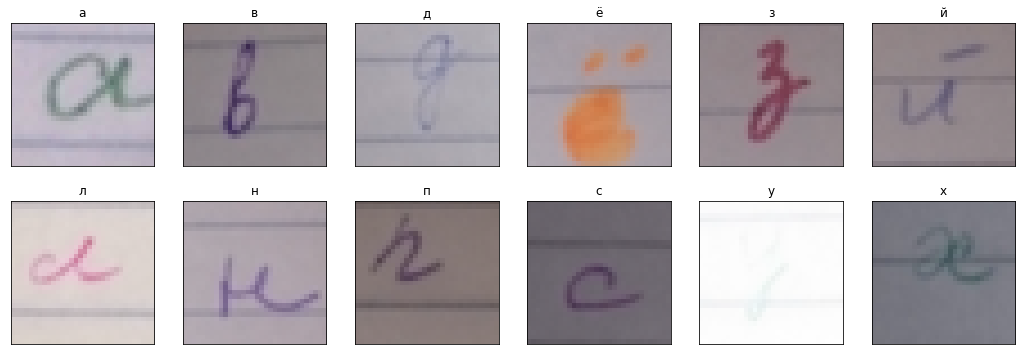

In [10]:
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*100])
    display_images(files[i*100], ax)

## Step 2. Save and Load the Data¶
The data tensors can be saved in the appropriate format of files .h5.

In [11]:
# Create the tensor file
with h5py.File('LetterColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.create_dataset('backgrounds', data = backgrounds)
    f.close()

In [12]:
# Read the h5 file
f = h5py.File('LetterColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [13]:
# Create tensors and targets
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (7590, 32, 32, 3)
Target shape (7590,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [14]:
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  б


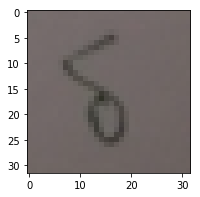

In [15]:
# Read and display a tensor using Matplotlib
print('Label: ', letters[2000])
plt.figure(figsize=(3,3))
plt.imshow(tensors[2000]);

Create tensors of grayscaled images and display their shape.

In [16]:
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (7590, 32, 32)


Label:  б


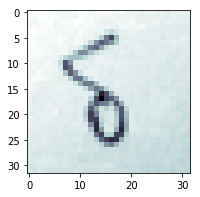

In [17]:
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[2000])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[2000], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [18]:
# Print the target unique values
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [19]:
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(7590, 33)

In [20]:
# One-hot encode the background targets
backgrounds = to_categorical(backgrounds, 3)
backgrounds.shape

(7590, 3)

### Add background

In [21]:
# Create multi-label targets
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(7590, 36)

### Split
#### Color Images
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 20%.

In [22]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [23]:
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Validating tensor's shape:", x_valid.shape)
print ("Validating target's shape", y_valid.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (6072, 32, 32, 3)
Training target's shape (6072, 33)
Validating tensor's shape: (759, 32, 32, 3)
Validating target's shape (759, 33)
Testing tensor's shape: (759, 32, 32, 3)
Testing target's shape (759, 33)


#### Grayscaled Images

In [24]:
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [25]:
# Reshape the grayscaled data
x_train2, x_test2, x_valid2 = \
x_train2.reshape(-1, 32, 32, 1), x_test2.reshape(-1, 32, 32, 1), x_valid2.reshape(-1, 32, 32, 1)

In [26]:
# Print the shape
print ("Training grayscaled tensor's shape:", x_train2.shape)
print ("Training grayscaled target's shape", y_train2.shape)
print ("Validating grayscaled tensor's shape:", x_valid2.shape)
print ("Validating grayscaled target's shape", y_valid2.shape)
print ("Testing grayscaled tensor's shape:", x_test2.shape)
print ("Testing grayscaled target's shape", y_test2.shape)

Training grayscaled tensor's shape: (6072, 32, 32, 1)
Training grayscaled target's shape (6072, 33)
Validating grayscaled tensor's shape: (759, 32, 32, 1)
Validating grayscaled target's shape (759, 33)
Testing grayscaled tensor's shape: (759, 32, 32, 1)
Testing grayscaled target's shape (759, 33)


In [27]:
# Convert images from grayscaled to RGB
x_train2_tensor = tf.image.grayscale_to_rgb(x_train2, name=None)
x_test2_tensor = tf.image.grayscale_to_rgb(x_test2, name=None)
x_valid2_tensor = tf.image.grayscale_to_rgb(x_valid2, name=None)
# Run tensorflow session
sess = tf.Session()
with sess.as_default():
    x_train2_color = x_train2_tensor.eval()
    x_test2_color = x_test2_tensor.eval()
    x_valid2_color = x_valid2_tensor.eval()
# Check the shape    
x_train2_color.shape, x_test2_color.shape, x_valid2_color.shape

((6072, 32, 32, 3), (759, 32, 32, 3), (759, 32, 32, 3))

#### Multi-label targets, color images

In [28]:
# Split with multi-label targets
x_train3, x_test3, y_train3, y_test3 = train_test_split(tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [29]:
# Print the shape
print ("Training tensor's shape:", x_train3.shape)
print ("Training target's shape", y_train3.shape)
print ("Validating tensor's shape:", x_valid3.shape)
print ("Validating target's shape", y_valid3.shape)
print ("Testing tensor's shape:", x_test3.shape)
print ("Testing target's shape", y_test3.shape)

Training tensor's shape: (6072, 32, 32, 3)
Training target's shape (6072, 36)
Validating tensor's shape: (759, 32, 32, 3)
Validating target's shape (759, 36)
Testing tensor's shape: (759, 32, 32, 3)
Testing target's shape (759, 36)


In [30]:
# Create a list of targets
y_train3_list = [y_train3[:, :33], y_train3[:, 33:]]
y_test3_list = [y_test3[:, :33], y_valid3[:, 33:]]
y_valid3_list = [y_valid3[:, :33], y_valid3[:, 33:]]

#### Multi-label targets, grayscaled images

In [31]:
# Split the grayscaled data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [32]:
# Reshape the grayscaled data
x_train4, x_test4, x_valid4 = \
x_train4.reshape(-1, 32, 32, 1), x_test4.reshape(-1, 32, 32, 1), x_valid4.reshape(-1, 32, 32, 1)

In [33]:
# Print the shape
print ("Training grayscaled tensor's shape:", x_train4.shape)
print ("Training grayscaled target's shape", y_train4.shape)
print ("Validating grayscaled tensor's shape:", x_valid4.shape)
print ("Validating grayscaled target's shape", y_valid4.shape)
print ("Testing grayscaled tensor's shape:", x_test4.shape)
print ("Testing grayscaled target's shape", y_test4.shape)

Training grayscaled tensor's shape: (6072, 32, 32, 1)
Training grayscaled target's shape (6072, 36)
Validating grayscaled tensor's shape: (759, 32, 32, 1)
Validating grayscaled target's shape (759, 36)
Testing grayscaled tensor's shape: (759, 32, 32, 1)
Testing grayscaled target's shape (759, 36)


In [34]:
# Create a list of targets
y_train4_list = [y_train4[:, :33], y_train4[:, 33:]]
y_test4_list = [y_test4[:, :33], y_test4[:, 33:]]
y_valid4_list = [y_valid4[:, :33], y_valid4[:, 33:]]

## Step 4. Create a One-Label Classification Model
### Color Images
Define a model architecture and compile the model for color images.

In [80]:
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25)) 
    
  #  model.add(Dense(128, activation='relu'))
  #  model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

model = model()

In [81]:
# Train the model
checkpointer = ModelCheckpoint(filepath='weights.best.letters.model.hdf5', 
                               verbose=2, save_best_only=True)
history = model.fit(x_train, y_train, 
                    epochs=30, batch_size=64, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer])

Train on 6072 samples, validate on 759 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 3.45812, saving model to weights.best.letters.model.hdf5
41s - loss: 3.4877 - acc: 0.0347 - val_loss: 3.4581 - val_acc: 0.0382
Epoch 2/30
Epoch 00001: val_loss improved from 3.45812 to 3.43572, saving model to weights.best.letters.model.hdf5
51s - loss: 3.4652 - acc: 0.0476 - val_loss: 3.4357 - val_acc: 0.0356
Epoch 3/30
Epoch 00002: val_loss did not improve
36s - loss: 3.4060 - acc: 0.0502 - val_loss: 3.5769 - val_acc: 0.0316
Epoch 4/30
Epoch 00003: val_loss did not improve
34s - loss: 3.3838 - acc: 0.0478 - val_loss: 3.6025 - val_acc: 0.0316
Epoch 5/30
Epoch 00004: val_loss did not improve
34s - loss: 3.3593 - acc: 0.0530 - val_loss: 3.5525 - val_acc: 0.0343
Epoch 6/30
Epoch 00005: val_loss did not improve
33s - loss: 3.3418 - acc: 0.0631 - val_loss: 3.5930 - val_acc: 0.0277
Epoch 7/30
Epoch 00006: val_loss did not improve
35s - loss: 3.3493 - acc: 0.0639 - val_loss: 3.5686 - val_acc:

We should have an accuracy greater than 3%

In [83]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.letters.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

759/759 [==============================] - 16s    


[2.3708257888773843, 0.30961791792091803]

Apply the ImageDataGenerator() function.

In [84]:
# Fit the model with ImageDataGenerator()
# TODO: Define parameters
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

generator = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                steps_per_epoch = steps, epochs = epochs,
                                validation_data = (x_valid, y_valid), 
                                callbacks=[checkpointer], verbose=2)

Epoch 1/10
Epoch 00000: val_loss improved from 2.39831 to 2.19329, saving model to weights.best.letters.model.hdf5
413s - loss: 2.4563 - acc: 0.2911 - val_loss: 2.1933 - val_acc: 0.3636
Epoch 2/10
Epoch 00001: val_loss improved from 2.19329 to 2.00158, saving model to weights.best.letters.model.hdf5
371s - loss: 2.2459 - acc: 0.3423 - val_loss: 2.0016 - val_acc: 0.4137
Epoch 3/10
Epoch 00002: val_loss did not improve
382s - loss: 2.0907 - acc: 0.3838 - val_loss: 2.0476 - val_acc: 0.4111
Epoch 4/10
Epoch 00003: val_loss improved from 2.00158 to 1.81775, saving model to weights.best.letters.model.hdf5
332s - loss: 1.9747 - acc: 0.4173 - val_loss: 1.8178 - val_acc: 0.4690
Epoch 5/10
Epoch 00004: val_loss improved from 1.81775 to 1.54299, saving model to weights.best.letters.model.hdf5
324s - loss: 1.8824 - acc: 0.4431 - val_loss: 1.5430 - val_acc: 0.5573
Epoch 6/10
Epoch 00005: val_loss did not improve
329s - loss: 1.7975 - acc: 0.4657 - val_loss: 1.8048 - val_acc: 0.4769
Epoch 7/10
Epoch

In [85]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.letters.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

736/759 [============================>.] - ETA: 0s

[1.5406798223261777, 0.55862977617814136]

Let's compare the results with classifying algorithms.

In [86]:
# Fit the classifier and get the accuracy score
y_train_c = np.array([np.argmax(y) for y in y_train])
y_test_c = np.array([np.argmax(y) for y in y_test])
clf = GradientBoostingClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.25296442687747034

In [87]:
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf2.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.21870882740447958

### Grayscaled Images
Define a model architecture and compile the model for grayscaled images.

In [35]:
def gray_model():
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_model = gray_model()

In [36]:
# Train the model
gray_checkpointer = ModelCheckpoint(filepath='weights.best.letters.gray_model.hdf5', 
                                    verbose=2, save_best_only=True)
gray_history = gray_model.fit(x_train2, y_train2, 
                              epochs=100, batch_size=64, verbose=0,
                              validation_data=(x_valid2, y_valid2),
                              callbacks=[gray_checkpointer])

Epoch 00000: val_loss improved from inf to 3.48991, saving model to weights.best.letters.gray_model.hdf5
Epoch 00001: val_loss improved from 3.48991 to 3.42063, saving model to weights.best.letters.gray_model.hdf5
Epoch 00002: val_loss improved from 3.42063 to 3.40563, saving model to weights.best.letters.gray_model.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 3.40563 to 3.37622, saving model to weights.best.letters.gray_model.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 3.37622 to 3.35555, saving model to weights.best.letters.gray_model.hdf5
Epoch 00013: val_loss improved from 3.35555 to 3.34345, saving model to weights.best.letters.gray_model.hdf5
Epoch 00014: val_loss did not improve
Epoch 00

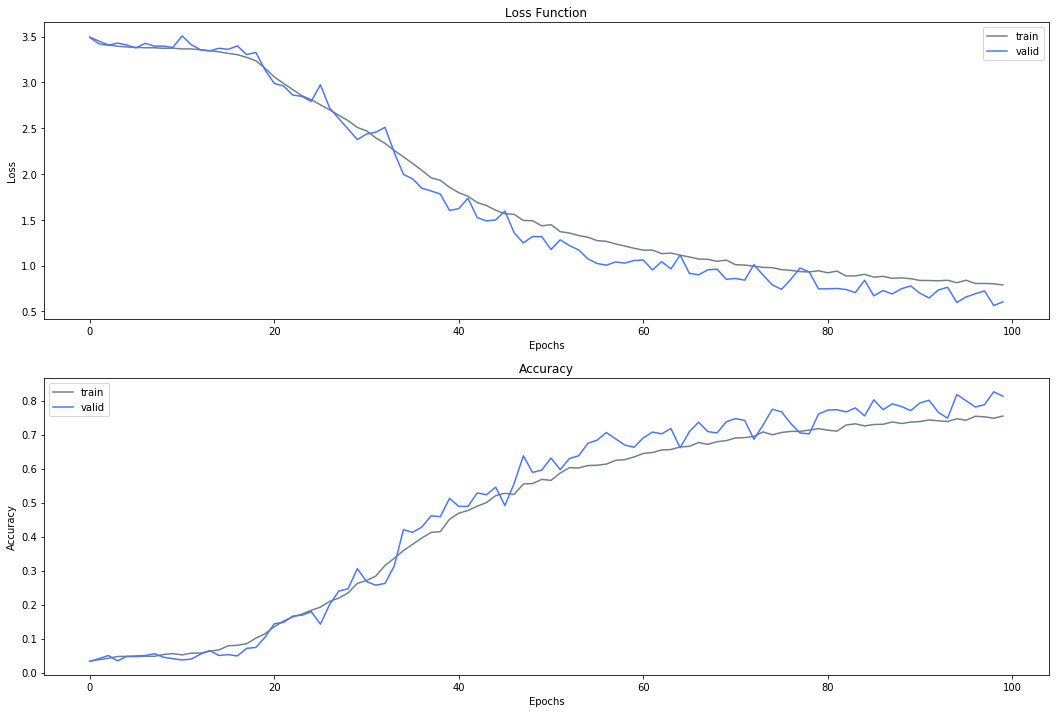

In [37]:
# Plot the training history
history_plot(gray_history, 0)

Try to reach an accuracy greater than 80%

In [38]:
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.letters.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

759/759 [==============================] - 5s     


[0.59680567750503577, 0.8234519101728407]

Apply the ImageDataGenerator() function.

In [39]:
# Fit the model with ImageDataGenerator()
# TODO: Define parameters
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

gray_generator = gray_model.fit_generator(data_generator.flow(x_train2, y_train2, batch_size=64),
                                          steps_per_epoch = steps, epochs = epochs,
                                          validation_data = (x_test2, y_test2), 
                                          callbacks=[gray_checkpointer], verbose=2)

Epoch 1/10
Epoch 00000: val_loss did not improve
306s - loss: 1.3917 - acc: 0.5991 - val_loss: 0.7545 - val_acc: 0.7931
Epoch 2/10
Epoch 00001: val_loss did not improve
313s - loss: 1.3115 - acc: 0.6195 - val_loss: 0.5701 - val_acc: 0.8327
Epoch 3/10
Epoch 00002: val_loss did not improve
337s - loss: 1.2793 - acc: 0.6314 - val_loss: 0.6493 - val_acc: 0.8103
Epoch 4/10
Epoch 00003: val_loss improved from 0.56455 to 0.53525, saving model to weights.best.letters.gray_model.hdf5
330s - loss: 1.2487 - acc: 0.6383 - val_loss: 0.5352 - val_acc: 0.8406
Epoch 5/10
Epoch 00004: val_loss did not improve
316s - loss: 1.2331 - acc: 0.6450 - val_loss: 0.5956 - val_acc: 0.8235
Epoch 6/10
Epoch 00005: val_loss did not improve
335s - loss: 1.2352 - acc: 0.6487 - val_loss: 0.5874 - val_acc: 0.8195
Epoch 7/10
Epoch 00006: val_loss did not improve
299s - loss: 1.2192 - acc: 0.6542 - val_loss: 0.6007 - val_acc: 0.8235
Epoch 8/10
Epoch 00007: val_loss did not improve
294s - loss: 1.2197 - acc: 0.6533 - val_

In [40]:
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.letters.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

736/759 [============================>.] - ETA: 0s

[0.53524808253852429, 0.84057971045904956]

Let's compare the results with classifying algorithms.

In [41]:
# Fit the classifier and get the accuracy score
y_train2_c = np.array([np.argmax(y) for y in y_train2])
y_test2_c = np.array([np.argmax(y) for y in y_test2])
clf = GradientBoostingClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.22924901185770752

In [42]:
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf2.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.1541501976284585

## Step 5. Create a Multi-Label Classification Model
### Color Images

In [35]:
def multi_model():    
    model_input = Input(shape=(32, 32, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
#    x = Dense(128, activation='relu')(x)    
#    x = Dropout(0.25)(x)    
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [36]:
# Display the model architecture
multi_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 32)    2432        input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 16, 16, 32)    0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 16, 16, 32)    0           max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [37]:
# Train the model
multi_checkpointer = ModelCheckpoint(filepath='weights.best.letters.multi.hdf5', 
                                     verbose=2, save_best_only=True)
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_test3, y_test3_list), 
                                epochs=30, batch_size=64, verbose=0, 
                                callbacks=[multi_checkpointer])

Epoch 00000: val_loss improved from inf to 4.24103, saving model to weights.best.letters.multi.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 4.24103 to 4.21858, saving model to weights.best.letters.multi.hdf5
Epoch 00003: val_loss improved from 4.21858 to 4.14341, saving model to weights.best.letters.multi.hdf5
Epoch 00004: val_loss improved from 4.14341 to 4.09419, saving model to weights.best.letters.multi.hdf5
Epoch 00005: val_loss improved from 4.09419 to 4.09170, saving model to weights.best.letters.multi.hdf5
Epoch 00006: val_loss improved from 4.09170 to 4.08563, saving model to weights.best.letters.multi.hdf5
Epoch 00007: val_loss improved from 4.08563 to 4.07615, saving model to weights.best.letters.multi.hdf5
Epoch 00008: val_loss improved from 4.07615 to 3.96762, saving model to weights.best.letters.multi.hdf5
Epoch 00009: val_loss improved from 3.96762 to 3.82059, saving model to weights.best.letters.multi.hdf5
Epoch 00010: val_loss improved

We should have an accuracy greater than 3% for the first target (letter) and 30% for the second target (background).

In [38]:
# Load the model with the best validation accuracy
multi_model.load_weights('weights.best.letters.multi.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("First label. Accuracy: %.2f%%" % (multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_scores[4]*100))

Scores: 
 [2.7836263308569063, 1.7998781450809382, 0.98374816928456421, 0.51646903742286365, 0.6613965736547478]
First label. Accuracy: 51.65%
Second label. Accuracy: 66.14%


### Grayscaled Images

In [59]:
def gray_multi_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Dense(256, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(3, activation='softmax')(x)
       
    model = Model(inputs=model_input, outputs=[y1, y2])
    # TODO: Compile the model

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])   
    return model

gray_multi_model = gray_multi_model()

In [60]:
# Train the model
gray_multi_checkpointer = ModelCheckpoint(filepath='weights.best.letters.gray_multi.hdf5', 
                                          verbose=2, save_best_only=True)
gray_multi_history = gray_multi_model.fit(x_train4, y_train4_list, 
                                          validation_data=(x_test4, y_test4_list), 
                                          epochs=200, batch_size=64, verbose=0, 
                                          callbacks=[gray_multi_checkpointer])

Epoch 00000: val_loss improved from inf to 4.21238, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00001: val_loss improved from 4.21238 to 4.14618, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00002: val_loss improved from 4.14618 to 4.09458, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 4.09458 to 4.01250, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 4.01250 to 3.99474, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 3.99474 to 3.98766, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00013: val_loss improved from 3.98766 to 3.94370, saving model to weights.best

Epoch 00121: val_loss did not improve
Epoch 00122: val_loss did not improve
Epoch 00123: val_loss did not improve
Epoch 00124: val_loss did not improve
Epoch 00125: val_loss did not improve
Epoch 00126: val_loss did not improve
Epoch 00127: val_loss improved from 1.32442 to 1.30072, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00128: val_loss improved from 1.30072 to 1.19615, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss improved from 1.19615 to 1.16374, saving model to weights.best.letters.gray_multi.hdf5
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did n

We should have an accuracy greater than 3% for the first target (letter) and 30% for the second target (background).

In [61]:
# Load the model with the best validation accuracy
gray_multi_model.load_weights('weights.best.letters.gray_multi.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test4, y_test4_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("First label. Accuracy: %.2f%%" % (gray_multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))

Scores: 
 [1.0246299333251982, 0.98210754664676148, 0.042522395086107834, 0.72200263543876575, 0.98814229249011853]
First label. Accuracy: 72.20%
Second label. Accuracy: 98.81%


---
## Step 6. Keras Applications
Choose one of the keras applications and try to reach an accuracy greater than 30%
### Color Images

In [35]:
# Create bottleneck features
resize_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                           for i in range(0, len(x_train))]).astype('float32')
resize_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                          for i in range(0, len(x_test))]).astype('float32')
resize_x_valid = np.array([scipy.misc.imresize(x_valid[i], (139, 139, 3)) 
                          for i in range(0, len(x_valid))]).astype('float32')

iv3_x_train = preprocess_input(resize_x_train)
iv3_x_test = preprocess_input(resize_x_test)
iv3_x_valid = preprocess_input(resize_x_valid)

iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x_train_bn = iv3_base_model.predict(iv3_x_train)
x_test_bn = iv3_base_model.predict(iv3_x_test)
x_valid_bn = iv3_base_model.predict(iv3_x_valid)

In [36]:
# Save bottleneck features
x_train_bn = np.squeeze(x_train_bn)
x_test_bn = np.squeeze(x_test_bn)
x_valid_bn = np.squeeze(x_valid_bn)

np.save('x_train_bn.npy', x_train_bn)
np.save('x_test_bn.npy', x_test_bn)
np.save('x_valid_bn.npy', x_valid_bn)

In [37]:
# Load bottleneck features
x_train_bn = np.load('x_train_bn.npy')
x_test_bn = np.load('x_test_bn.npy')
x_valid_bn = np.load('x_valid_bn.npy')

In [38]:
def iv3_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    
    # TODO: Compile the model 
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])    

    return model

iv3_model = iv3_model()

In [39]:
# Fit the model 
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.letters.iv3.hdf5', 
                                     verbose=2, save_best_only=True)
iv3_history = iv3_model.fit(x_train_bn, y_train, 
                            validation_data=(x_valid_bn, y_valid),
                            epochs=50, batch_size=64, 
                            callbacks=[iv3_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 2.65806, saving model to weights.best.letters.iv3.hdf5
Epoch 00001: val_loss improved from 2.65806 to 2.33254, saving model to weights.best.letters.iv3.hdf5
Epoch 00002: val_loss improved from 2.33254 to 2.00503, saving model to weights.best.letters.iv3.hdf5
Epoch 00003: val_loss improved from 2.00503 to 1.79829, saving model to weights.best.letters.iv3.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 1.79829 to 1.75493, saving model to weights.best.letters.iv3.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 1.75493 to 1.52034, saving model to weights.best.letters.iv3.hdf5
Epoch 00008: val_loss improved from 1.52034 to 1.42241, saving model to weights.best.letters.iv3.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 1.42241 to 1.36830, saving model to weights.best.letters.iv3.hdf5
Epoch 00012: val_loss improved from 

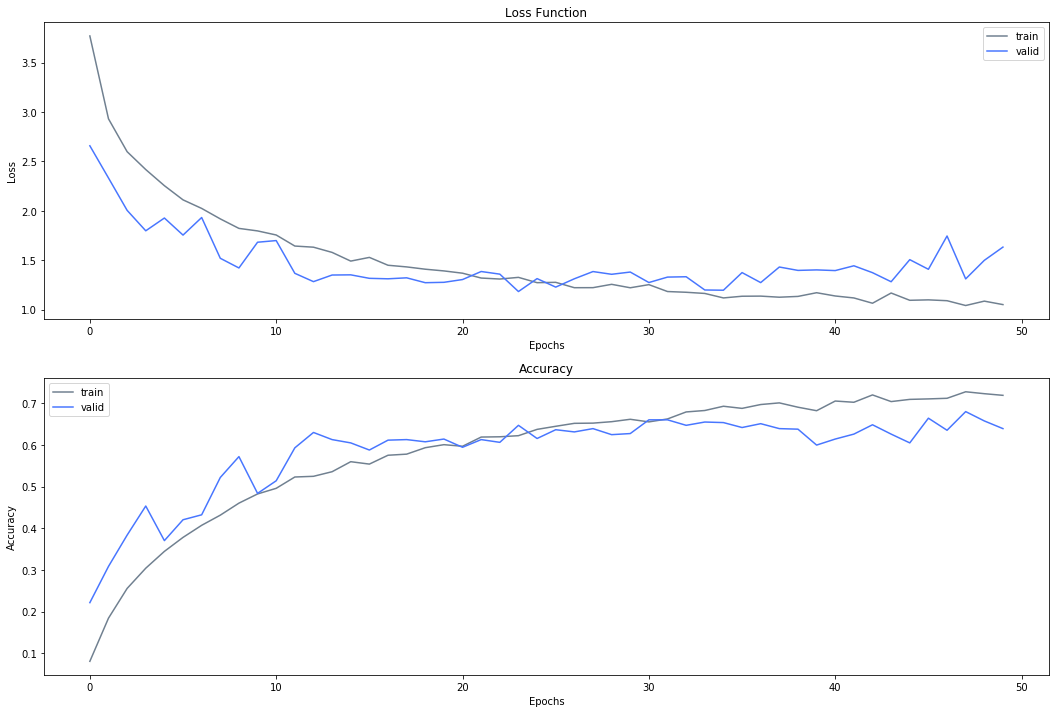

In [40]:
# Plot the training history
history_plot(iv3_history, 0)

In [41]:
# Load the model with the best validation accuracy
iv3_model.load_weights('weights.best.letters.iv3.hdf5')
# Calculate classification accuracy on the testing set
iv3_scores = iv3_model.evaluate(x_test_bn, y_test)
print("Accuracy: %.2f%%" % (iv3_scores[1]*100))
iv3_scores

704/759 [==========================>...] - ETA: 0sAccuracy: 64.43%


[1.2389546483558787, 0.64426877478208777]

### Grayscaled Images

In [42]:
# Create bottleneck features
resize_x_train2 = np.array([scipy.misc.imresize(x_train2_color[i], (139, 139, 3)) 
                            for i in range(0, len(x_train2_color))]).astype('float32')
resize_x_test2 = np.array([scipy.misc.imresize(x_test2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_test2_color))]).astype('float32')
resize_x_valid2 = np.array([scipy.misc.imresize(x_valid2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_valid2_color))]).astype('float32')

iv3_x_train2 = preprocess_input(resize_x_train2)
iv3_x_test2 = preprocess_input(resize_x_test2)
iv3_x_valid2 = preprocess_input(resize_x_valid2)

iv3_base_model2 = InceptionV3(weights='imagenet', include_top=False)
x_train_bn2 = iv3_base_model2.predict(iv3_x_train2)
x_test_bn2 = iv3_base_model2.predict(iv3_x_test2)
x_valid_bn2 = iv3_base_model2.predict(iv3_x_valid2)

In [43]:
# Save bottleneck features
x_train_bn2 = np.squeeze(x_train_bn2)
x_test_bn2 = np.squeeze(x_test_bn2)
x_valid_bn2 = np.squeeze(x_valid_bn2)

np.save('x_train_bn2.npy', x_train_bn2)
np.save('x_test_bn2.npy', x_test_bn2)
np.save('x_valid_bn2.npy', x_valid_bn2)

In [44]:
# Load bottleneck features
x_train_bn2 = np.load('x_train_bn2.npy')
x_test_bn2 = np.load('x_test_bn2.npy')
x_valid_bn2 = np.load('x_valid_bn2.npy')

In [45]:
def iv3_gray_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn2.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    # TODO: Compile the model     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

iv3_gray_model = iv3_gray_model()

In [46]:
# Fit the model 
iv3_gray_checkpointer = ModelCheckpoint(filepath='weights.best.letters.iv3_gray.hdf5', 
                                        verbose=2, save_best_only=True)
iv3_gray_history = iv3_gray_model.fit(x_train_bn2, y_train2, 
                                      validation_data=(x_valid_bn2, y_valid2),
                                      epochs=50, batch_size=64, 
                                      callbacks=[iv3_gray_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 2.65396, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00001: val_loss improved from 2.65396 to 2.24445, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00002: val_loss improved from 2.24445 to 2.00583, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00003: val_loss improved from 2.00583 to 1.98057, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00004: val_loss improved from 1.98057 to 1.65476, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 1.65476 to 1.36385, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00007: val_loss improved from 1.36385 to 1.23775, saving model to weights.best.letters.iv3_gray.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 1.23775 to 1.22006, saving model to weights.best.letters.iv3_gray.h

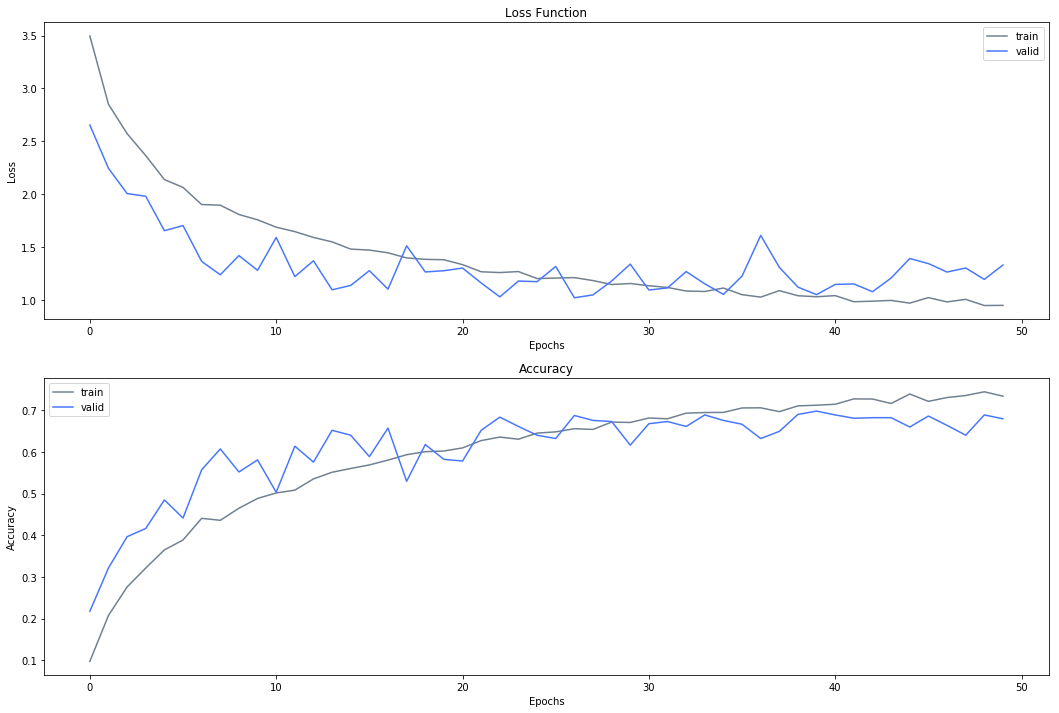

In [47]:
# Plot the training history
history_plot(iv3_gray_history, 0)

In [48]:
# Load the model with the best validation accuracy
iv3_gray_model.load_weights('weights.best.letters.iv3_gray.hdf5')
# Calculate classification accuracy on the testing set
iv3_gray_scores = iv3_gray_model.evaluate(x_test_bn2, y_test2)
print("Accuracy: %.2f%%" % (iv3_gray_scores[1]*100))
iv3_gray_scores

736/759 [============================>.] - ETA: 0sAccuracy: 66.01%


[1.1513739697075644, 0.66007905177605164]

## Step 7. Predictions
Display predictions for the models with the best accuracy.
### Color Images

In [49]:
# Create a list of symbols
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

In [50]:
# Model predictions for the testing dataset
y_test_predict = iv3_model.predict_classes(x_test_bn)

759/759 [==============================] - 60s    


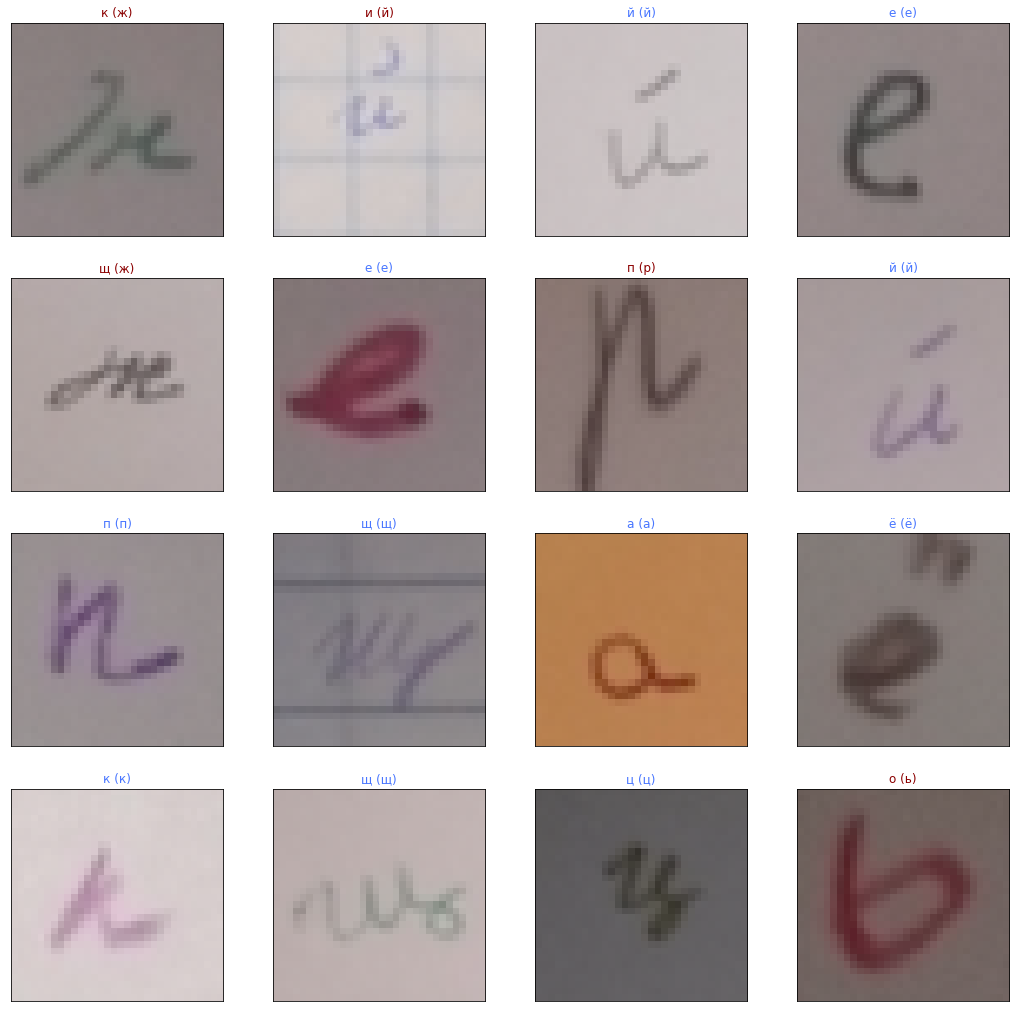

In [51]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

### Grayscaled Images

In [59]:
# Model predictions for the testing dataset
y_test2_predict = gray_model.predict_classes(x_test2)

720/720 [==============================] - 4s     


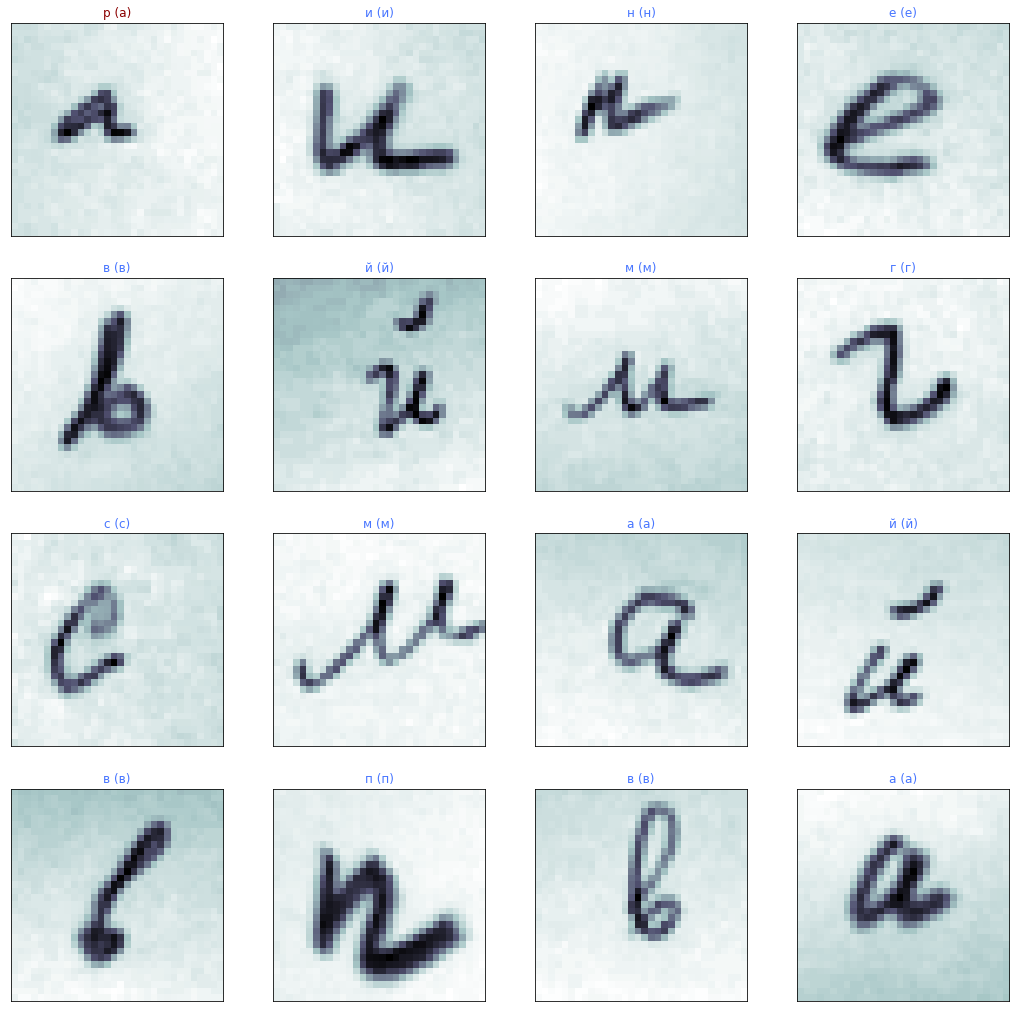

In [62]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test2.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test2[idx]), cmap=cm.bone)
    pred_idx = y_test2_predict[idx]
    true_idx = np.argmax(y_test2[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))